In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
import imp
import numpy as np
from scipy import constants

import lsst.daf.persistence as daf_persistence
from lsst.sims.photUtils import Bandpass, PhotometricParameters
from lsst.utils import getPackageDir

In [3]:
def look(img, range=None, x_range=None, y_range=None):
    """Simple function to wrap matplotlib and display an image with a colorbar."""
    plt.figure(figsize=(16, 6))
    if range is None:
        range = [np.min(img), np.max(img)]
    img_use = np.clip(img, range[0], range[1])
    if x_range is not None:
        x0 = int(x_range[0])
        x1 = int(x_range[1])
        if x0 < 0:
            img_use = np.roll(img_use, -x0, axis=1)
            x1 -= x0
            x0 = 0
        img_use = img_use[:, x0: x1]
    if y_range is not None:
        y0 = int(y_range[0])
        y1 = int(y_range[1])
        if y0 < 0:
            img_use = np.roll(img_use, -y0, axis=0)
            y1 -= y0
            y0 = 0
        img_use = img_use[y0: y1, :]
    fig_show = plt.imshow(img_use, interpolation='none', origin='lower', cmap=cm.rainbow)
    plt.colorbar(fig_show, orientation='vertical', shrink=1)
#    cbar.set_label('DCR (arcsec)', labelpad=0)
    plt.show()

In [4]:
repository = "/Users/sullivan/LSST/simulations/test6/output_data"
obsid_range = [200, 224, 4]
band_name = "g"

In [5]:
imp.load_source('dcr_fft_correction', '/Users/sullivan/LSST/LSST-DCR/experimental_DCR/python/dcr_fft_correction.py')
from dcr_fft_correction import DcrCorrection

In [6]:
self = DcrCorrection(n_step=3, repository=repository, obsid_range=obsid_range, band_name=band_name)

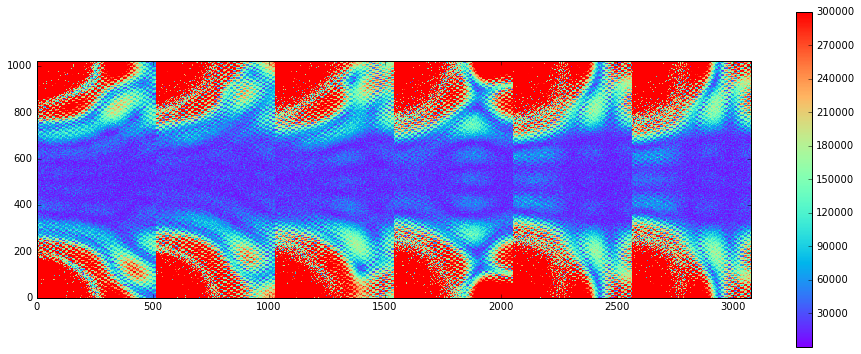

In [7]:
look(np.hstack(np.abs(self.fourier)),range=[-3e5,3e5])

In [17]:
self.build_model(1e-4)

In [18]:
model_fourier = self.model[0,:,:]

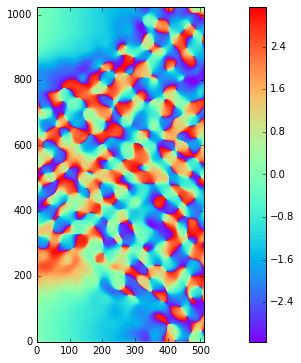

In [19]:
look(np.angle(self.dcr_phase[0,0,:,:]))

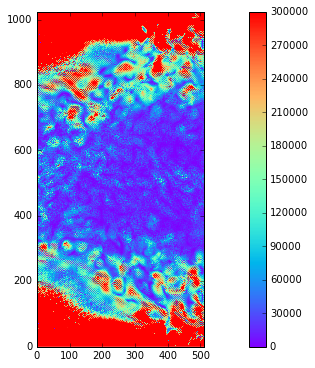

In [20]:
look(np.abs(self.model[0,:,:]*self.dcr_phase[0,0,:,:]),range=[-3e5,3e5])

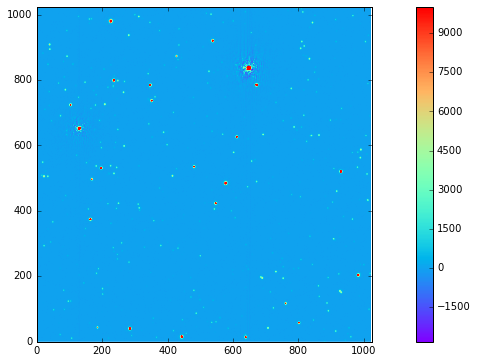

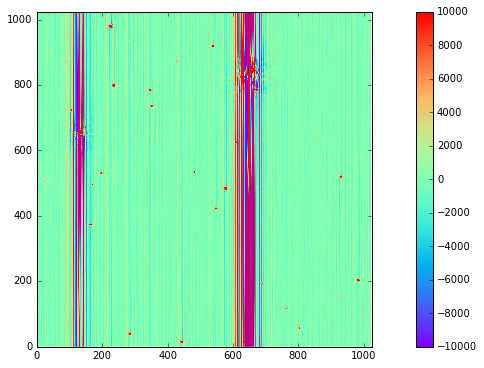

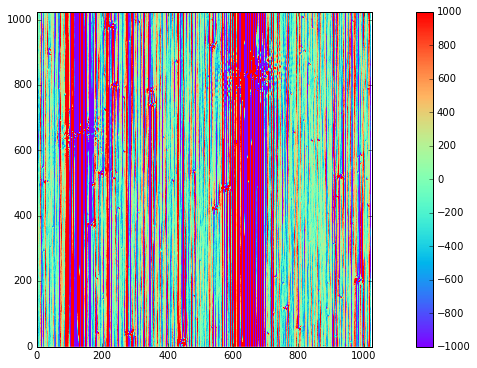

In [21]:
# output_directory='/Users/sullivan/LSST/simulations/test6/'
template_exposure_gen = self.generate_templates_from_model(obsid_range=[208,210])
im_arr = []
for exp in template_exposure_gen:
    im_arr.append(exp.getMaskedImage().getImage().getArray())
for im in im_arr:
    look(im, range=[-1e4,1e4])
look(im_arr[1] - im_arr[0],range=[-1e3,1e3])

In [199]:
calexp_208 = self.butler.get("calexp", dataId={'visit': 208, 'raft': '2,2', 'sensor': '1,1', 'filter': 'g'})
calexp_212 = self.butler.get("calexp", dataId={'visit': 212, 'raft': '2,2', 'sensor': '1,1', 'filter': 'g'})
calexp_216 = self.butler.get("calexp", dataId={'visit': 216, 'raft': '2,2', 'sensor': '1,1', 'filter': 'g'})
calexp_220 = self.butler.get("calexp", dataId={'visit': 220, 'raft': '2,2', 'sensor': '1,1', 'filter': 'g'})

In [348]:
mask=calexp.getMaskedImage().getMask().getArray()

In [52]:
mask2 = calexp.getMaskedImage().getMask()

In [196]:
np.floor(-0.5)

-1.0

In [209]:
def _calc_psf_kernel(exposure, offset):

    y_size = exposure.getHeight()
    x_size = exposure.getWidth()
    psf_img = exposure.getPsf().computeImage(offset).getArray()
    psf_y_size, psf_x_size = psf_img.shape
    psf = np.zeros((y_size, x_size), dtype=psf_img.dtype)
    dx = np.floor(offset[0])
    dy = np.floor(offset[1])
    y0 = int(y_size//2 - psf_y_size//2 + dx)
    y1 = y0 + psf_y_size
    x0 = int(x_size//2 - psf_x_size//2 + dy)
    x1 = x0 + psf_x_size
    psf[y0: y1, x0: x1] = psf_img
    return(np.fft.rfft2(np.fft.fftshift(psf)))

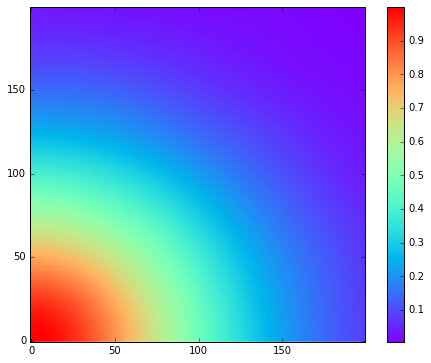

In [210]:
look(np.real(_calc_psf_kernel(calexp_208,afwGeom.Point2D(0,.5))),x_range=[0,200],y_range=[0,200])

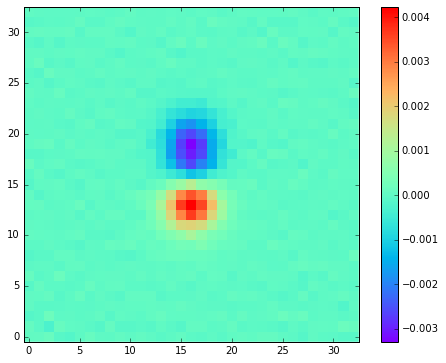

In [217]:
import lsst.afw.geom as afwGeom
pt = afwGeom.Point2D(20,.5)
offset = (20,0)
pt2 = afwGeom.Point2D(offset[0],offset[1])
psf = self.exposures[0].getPsf()
psf_img=psf.computeImage(pt)
psf_img2=psf.computeImage(pt2)
look(psf_img.getArray() - psf_img2.getArray())

In [508]:
look(np.fft.fftshift(np.abs(np.fft.fft2(calexp.getMaskedImage().getImage().getArray()))),
     x_range=[400,600],y_range=[400,600])

NameError: name 'calexp' is not defined

In [78]:
fimg_208 = np.fft.fftshift(np.fft.fft2(calexp_208.getMaskedImage().getImage().getArray()))
fimg_212 = np.fft.fftshift(np.fft.fft2(calexp_212.getMaskedImage().getImage().getArray()))
fimg_216 = np.fft.fftshift(np.fft.fft2(calexp_216.getMaskedImage().getImage().getArray()))
fimg_220 = np.fft.fftshift(np.fft.fft2(calexp_220.getMaskedImage().getImage().getArray()))

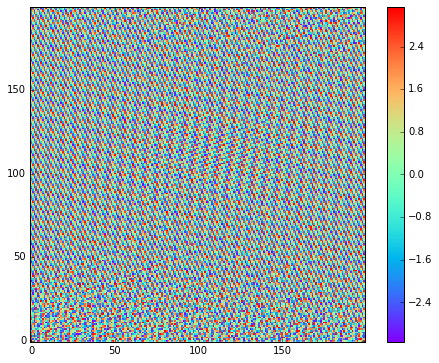

In [176]:
look(np.angle(fimg_208-fimg_220),x_range=[400,600],y_range=[400,600])

In [98]:
import lsst.afw.image as afwImage

In [101]:
afwImage.MaskU_getPlaneBitMask("DETECTED")

32

In [350]:
image = calexp_208.getMaskedImage().getImage().getArray()
mask = np.ones_like(image)
detected_bit = exp.getMaskedImage().getMask().getPlaneBitMask("DETECTED")
mask[np.bitwise_and(exp.getMaskedImage().getMask().getArray(), detected_bit) != detected_bit] = 0.

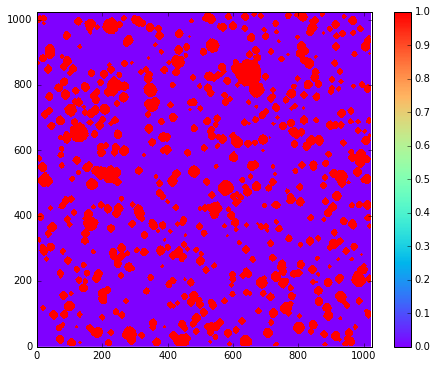

In [363]:
look(mask)

In [381]:
fimage = np.fft.rfft2(image)
fimage2 = np.fft.rfft2(calexp_212.getMaskedImage().getImage().getArray())
fmask = np.fft.rfft2(1 - mask) * np.std(image[mask == 0])

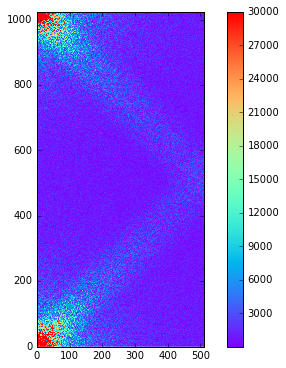

In [384]:
look(np.abs(fmask),range=[-3e4,3e4])

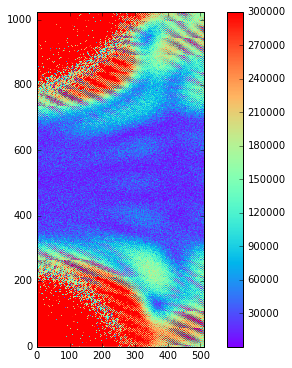

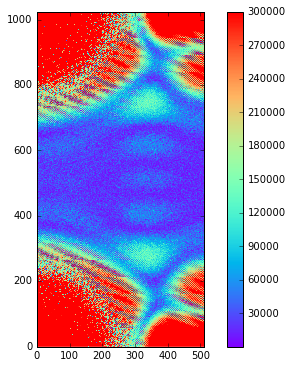

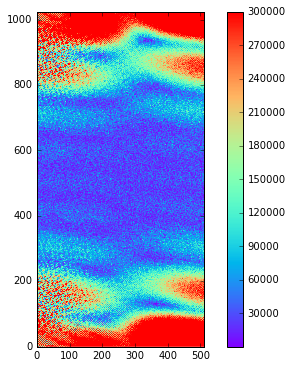

In [390]:
look(np.abs(fimage - fmask),range=[-3e5,3e5])
look(np.abs(fimage2 - fmask),range=[-3e5,3e5])
look(np.abs(fimage - fimage2),range=[-3e5,3e5])

In [421]:
a = np.asarray([[1,2,3,4],[2,4,6,8]])

In [423]:
a.dot(a.T)

array([[ 30,  60],
       [ 60, 120]])

In [420]:
a

array([[1, 2, 3, 4]])

In [428]:
fimage.dtype

dtype('complex128')

In [432]:
b=np.zeros((3,2),dtype=fimage.dtype)

In [433]:
b.dtype

dtype('complex128')

In [434]:
b

array([[ 0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j]])

In [435]:
c=b[0,:]